# Optimal/Horne extraction exploration

This is not currently an option in `specreduce`, so I adapted a preliminary workflow from a JDAT Notebook and the original paper introducing the method.

I left notes *[in brackets]* on how I understand these steps in comparison to what should occur in the extraction step of the block-style workflow we envision for `specreduce`.

### Steps in [Spectral Extraction-static.ipynb](https://spacetelescope.github.io/jdat_notebooks/notebooks/optimal_extraction/Spectral%20Extraction-static.html):

1. Define extraction region *[user should provide an appropriate image]*
2. Pick a slice *[user should have done this]*
3. Define extraction kernel *[user does most of this through class arguments]*
    - Select PSF template
    - Choose a polynomial for background fitting
4. Fit extraction kernel to initial slice
5. Fit geometric distortion
    - Determine cross-dispersion bins for trace fitting
    - Fit a kernel to each bin to find trace center *[we already have this from the trace object]*
    - Polynomial fit of trace centers
6. Combine composite model with 2D image to create output 1D spectrum
    - Create variance image
    - Generate 1D spectrum
7. Compare with 1D spectrum

### Steps in [Horne (1986)](https://ui.adsabs.harvard.edu/abs/1986PASP...98..609H%2F/abstract)

1. Bias subtraction *[done in block of specreduce]*
2. Initial variance estimate
3. Fit sky background
    - "We therefore generally perform a least-squares polynomial fit to the sky data at each wavelength. Individual sky pixels are given weights inversely proportional to their variances as estimated in Step 2" *[overlaps with notebook's 3b]*
4. Extract standard spectrum and its variance
    - Subtract the sky background found in Step 3 from the image.
5. Construct spatial profile
6. Revise variance estimates
7. Mask cosmic ray hits
8. Extract optimal spectrum and its variance
9. Iterate Steps 5-8

I understand the first four steps as the standard procedure and the last five as add-ons that help squeeze out extra signal-to-noise.

# Procedure

I will follow steps from the notebook more closely with an eye on adding steps from the paper as we improve functionality. We are limiting to 2D spectra at the moment with an eye on supporting 3D spectra in the future.

## I. Prelude

### Imports

Clone the [kosmos repository](https://github.com/jradavenport/kosmos) and set its path as the `kosmos_path` variable near the end of this cell.

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import sys
from astropy.io import fits
from astropy.modeling import models, fitting
from astropy.visualization import simple_norm
from matplotlib.patches import Rectangle
from pathlib import Path
from specreduce import SpecreduceOperation

# enable import for kosmos objects. needed since it's not yet a proper package
# (it may pay to copy relevant kosmos code to specreduce?)
kosmos_path = '...'
sys.path.append(kosmos_path)
import kosmos

In [2]:
mpl.rcParams.update({'axes.titlesize': 18, 'axes.labelsize': 12,
                     'legend.fontsize': 12,  'axes.grid': False,
                     'grid.alpha': .5, 'grid.color': 'k',
                     'axes.edgecolor': 'k'})

### Get spectral files
Download them from this [Box folder](https://stsci.app.box.com/s/io2gk1r7di0ryhtnxuh4mevvyaj5oqmn) and replace the `...` in the following cell with their location on your machine.

In [3]:
download_dir = Path('...')

In [4]:
# 2d spectra
file_2d1 = download_dir / Path('legac_M1_v3.11_spec2d_126153.fits')
file_2d2 = download_dir / Path('legac_M1_v3.11_spec2d_127036.fits')

vlt_img1 = fits.getdata(file_2d1)
vlt_img2 = fits.getdata(file_2d2)

vlt_img1_head = fits.getheader(file_2d1)
vlt_img2_head = fits.getheader(file_2d2)

In [5]:
# 2d weights
file_2d_weight1 = download_dir / Path('legac_M1_v3.11_wht2d_126153.fits')
file_2d_weight2 = download_dir / Path('legac_M1_v3.11_wht2d_127036.fits')

vlt_weight1 = fits.getdata(file_2d_weight1)
vlt_weight2 = fits.getdata(file_2d_weight2)

vlt_weight1_head = fits.getheader(file_2d_weight1)
vlt_weight2_head = fits.getheader(file_2d_weight2)

In [6]:
# 1d references
file_1d1 = download_dir / Path('legac_M1_v3.11_spec1d_126153.fits')
file_1d2 = download_dir / Path('legac_M1_v3.11_spec1d_127036.fits')

vlt_ref1 = fits.getdata(file_1d1)
vlt_ref2 = fits.getdata(file_1d2)

vlt_ref1_head = fits.getheader(file_1d1)
vlt_ref2_head = fits.getheader(file_1d2)

In [7]:
vlt_img1_head[:10]

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                 6166 / length of data axis 1                          
NAXIS2  =                   81 / length of data axis 2                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
DATE    = '2015-01-26T12:24:07' / file creation date (YYYY-MM-DDThh:mm:ss UT)   
ORIGIN  = 'ESO     '           / European Southern Observatory                  

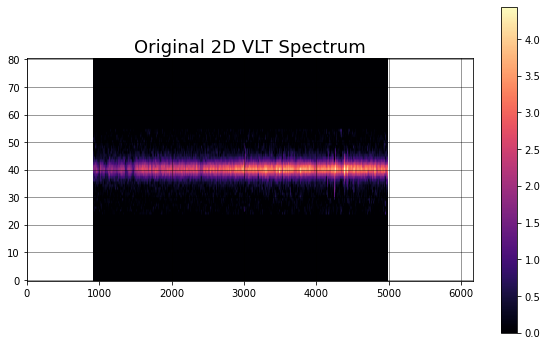

In [8]:
aspect_ratio = vlt_img1.shape[1] / (2 * vlt_img1.shape[0])

fig1, ax1 = plt.subplots(figsize=(10,6))
plot1 = ax1.imshow(vlt_img1,
                   vmin=0, vmax=np.nanmax(vlt_img1) / 2,
                   aspect=aspect_ratio, cmap=mpl.cm.magma, origin='lower')
fig1.colorbar(plot1)
ax1.set_title('Original 2D VLT Spectrum')
ax1.grid()

### Select extraction region
The 2D image has several NaN values, so I begin by slicing it down to its  finite region.

In [9]:
# borders of finite region
xx1 = np.argmin(np.isnan(vlt_img1[0]))
xx2 = vlt_img1.shape[-1] - np.argmin(np.isnan(vlt_img1[0][::-1]))
yy1 = np.flatnonzero(vlt_img1[:,xx1])[0]
yy2 = np.flatnonzero(vlt_img1[:,xx1])[-1]

extraction_region = vlt_img1[yy1:yy2, xx1:xx2]
print((xx1, xx2), (yy1, yy2))

(893, 4992) (24, 54)


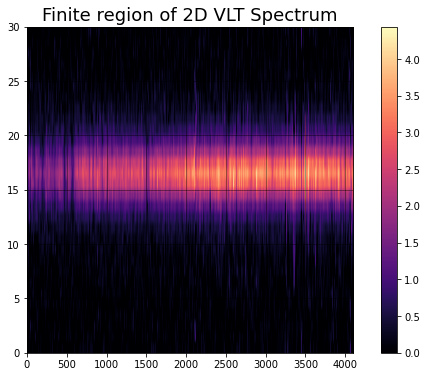

In [10]:
aspect_ratio2 = extraction_region.shape[1] / (1 * extraction_region.shape[0])
fig2, ax2 = plt.subplots(figsize=(10,6))
plot2 = ax2.imshow(extraction_region, aspect=aspect_ratio2,
                   vmin=0, vmax=extraction_region.max()/2,
                   cmap=mpl.cm.magma, origin='lower',
                   extent=(0, extraction_region.shape[-1],
                           0, extraction_region.shape[0]))
fig2.colorbar(plot2)
ax2.set_title('Finite region of 2D VLT Spectrum')
ax2.grid()

### Calculate a trace of the selected region

Generate a example trace object using code from the [kosmos](https://github.com/jradavenport/kosmos) repository. (Ideally, future users will create the output from this step by running through the previous step of the `specreduce` pipeline.)

In [11]:
vlt_ext_trace1 = kosmos.trace(extraction_region)

### Choose kernel slice parameters

Vary the width and start column of the extraction kernel to see where it lands on the updated version of `fig2`.

In [12]:
# select a kernel slice
slice_width = 500
column0 = 2000

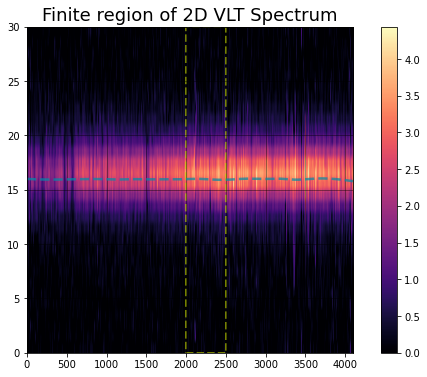

In [13]:
# begin remaking the extraction region plot
fig3, ax3 = plt.subplots(figsize=(10,6))
plot3 = ax3.imshow(extraction_region, aspect=aspect_ratio2,
                   vmin=0, vmax=extraction_region.max()/2,
                   cmap=mpl.cm.magma, origin='lower',
                   extent=(0, extraction_region.shape[-1],
                           0, extraction_region.shape[0]))
fig3.colorbar(plot3)
ax3.set_title('Finite region of 2D VLT Spectrum')
ax3.grid()

# add the trace
ax3.plot(vlt_ext_trace1, '--', color='#008ca8', lw=2.5, alpha=.7, label='trace')

# add the kernel slice
rect = Rectangle((column0, 0), slice_width, extraction_region.shape[0],
                 lw=2, edgecolor='#c4d600', alpha=.6, facecolor='none', linestyle='--')
ax3.add_patch(rect)

## II. Extraction
Once the kernel slice parameters are settled, we have everything needed to begin the extraction. I've created a template class with a superficially similar structure as the current version of `specreduce.extract.BoxcarExtract`.

This implementation could support some more arguments (as noted in the docstring) and be faster. It could also make better use of astropy objects like `Spectrum1D`.

In [14]:
class OptimalExtract(SpecreduceOperation):
    """
    Perform an optimal (Horne) extraction on a source in a two (or,
    in the future, three)-dimensional spectrum, producing a 1D spectrum.
    
    image : numpy.ndarray, required
        The input 2D/3D spectrum from which to extract a source.
        
    weights : numpy.ndarray, required
        Should have same shape as image.
        
    trace : numpy.nd.array, required [specreduce.trace.Trace? in the future?]
        The trace product created as output from the previous step of the
        specreduce pipeline.
        
    width : int, required
        The width (in columns) of the extraction kernel.
        
    column : int, required
        The column at the edge of the extraction kernel.
        [Do we want the center?]
        
    disp_axis : int, optional
        The index of the image array's dispersion axis.
        
    Possible additions: sky_offset, sky_width, cross_disp_axis (for 3D cases)
    """
    
    def __init__(self, image, weights, trace,
                 width, column, disp_axis=1,
                 # cross_disp_axis=...
                 ):

        if width < 1:
            raise ValueError('width must be >= 1')

        self.trace = trace
        self.width = width
        self.column = column
        self.disp_axis = disp_axis

        if disp_axis == 1:
            self.image = image
            self.weights = weights
            self.cross_disp_axis = 0
            self.disp_axis = 1

        elif disp_axis == 0:
            # transpose image so cross-dispersion axis is in y direction
            print('image transposed')
            self.image = image.T
            self.weights = weights.T
            self.cross_disp_axis = 0
            self.disp_axis = 1

        # elif self.disp_axis == 2 # for eventual 3D case
        else:
            raise ValueError('disp_axis must be 0 or 1')
            # raise ValueError('disp_axis must be 0, 1, or 2') # (in 3D case)
            
    def __call__(self):
        # nb2. isolate user-selected slice of image
        lambda1, lambda2, kernel_slice = self._coadd_kernel_columns()
        xd_pixels = np.arange(kernel_slice.shape[0]) # y plot dir / x spec dir

        # nb3a. fit source profile, using Gaussian model as a template
        # NOTE: could add argument for users to provide their own model
        gauss_prof = models.Gaussian1D(amplitude=kernel_slice.max(),
                                       mean=kernel_slice.argmax(),
                                       stddev=2)

        # nb3b. fit sky background, using polynomial model as a template
        # NOTE: should we be fitting the background if there will be a sky subtraction step?
        # if so, could add argument for users to provide their own model
        bkgrd_prof = models.Polynomial1D(2)

        # nb4. Fit extraction kernel to slice using Levenberg-Marquardt template
        ext_prof = gauss_prof + bkgrd_prof
        fitter = fitting.LevMarLSQFitter()
        fit_ext_kernel = fitter(ext_prof, xd_pixels, kernel_slice)

        # nb6a. Create variance image
        good_pix = ((self.image > 0)
                    * np.isfinite(self.image) * (self.weights != 0))
        weights_masked = np.ma.array(self.weights, mask=~good_pix)

        # make variance image
        # NOTE: could either add specific argument for variance image
        # OR the equation for converting the weights into variances
        # variance_image = np.ma.divide(1, weights_masked * pix_scale**4) # drizzlepac
        variance_image = np.ma.divide(1, weights_masked) # VLT

        # nb6b. Generate 1D spectrum
        spec1d = np.zeros(self.image.shape[-1])
        for col_px in range(self.image.shape[-1]):
            # set up this column's fit, using trace as mean
            kernel_col = fit_ext_kernel.copy()
            kernel_col.mean_0 = self.trace[col_px]
            # kernel_col.stddev_0 = self.fwhm_fit(x) # NOTE: support varying FWHMs?
            kernel_vals = kernel_col(xd_pixels)

            # fetch matching columns from original and variance images
            image_col = self.image[:, col_px]
            variance_col = variance_image[:, col_px]

            # calculate kernel normalization
            g_x = np.ma.sum(kernel_vals**2 / variance_col)
            if np.ma.is_masked(g_x):
                continue

            # sum by column weights
            weighted_col = np.ma.divide(image_col * kernel_vals, variance_col)
            spec1d[col_px] = np.ma.sum(weighted_col) / g_x

        return spec1d

    def _coadd_kernel_columns(self):
        # x plot dir / lambda spec dir
        border_left = max(0, self.column - self.width // 2)
        border_right = min(self.column + self.width // 2, self.image.shape[-1])
        coadd_region = np.arange(border_left, border_right)

        signal = self.image[:, coadd_region].sum(axis=1) / self.width
        return border_left, border_right, signal
    
class HorneExtract(OptimalExtract):
    pass

In [15]:
weight_region = vlt_weight1[yy1:yy2, xx1:xx2]
ext = OptimalExtract(extraction_region, weight_region,
                     vlt_ext_trace1, slice_width, column0)
result1d = ext()

## III. Results
Calculate wavelengths from the header and normalize the reference and extracted 1D spectra to allow for a comparison.

In [16]:
# account for strange format of header keys/values
wv0 = float(vlt_img1_head['HIERARCH ESO PRO REC1 PARAM4 VALUE'])
wv1 = float(vlt_img1_head['HIERARCH ESO PRO REC1 PARAM5 VALUE'])
wavelengths = np.linspace(wv0, wv1, len(result1d))

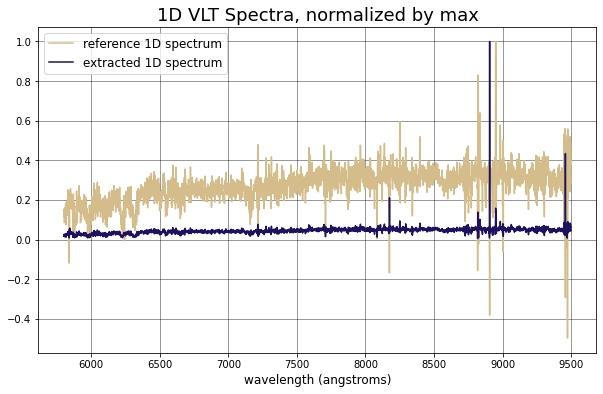

In [17]:
fig4, ax4 = plt.subplots(figsize=(10, 6))
ax4.plot(wavelengths, vlt_ref1[xx1:xx2] / vlt_ref1[xx1:xx2].max(),
         c='#d4bd8a', label='reference 1D spectrum')
ax4.plot(wavelengths, result1d / result1d.max(),
         c='#1d1160', label='extracted 1D spectrum')
ax4.set_xlabel('wavelength (angstroms)')
ax4.set_title('1D VLT Spectra, normalized by max')
ax4.grid()
ax4.legend()

### Remove weight from uncaught bad pixels

The three large emission "features" are caused by columns with intensity and weights concentrated at the edges, away from the source.

*NOTE: Should we be worried that these pixels weren't caught in the extraction process?*

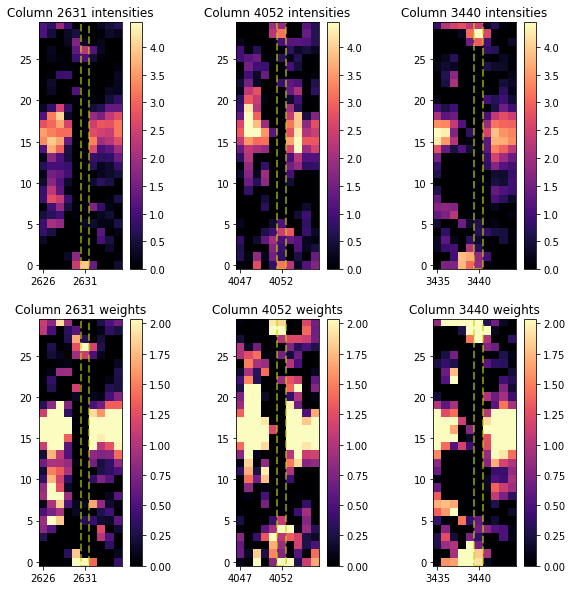

In [18]:
bad_pixels = np.argsort(result1d)[-3:]
buffer = 5

fig5, axs5 = plt.subplots(2, len(bad_pixels), figsize=(10, 10))

for i, arr in enumerate(np.rollaxis(axs5.T, 0)):
# for i, arr in enumerate(axs5, 0):
    # print(arr)
    ax0, ax1 = arr#.T
    region0 = bad_pixels[i] - buffer
    region1 = bad_pixels[i] + buffer
    
    pl0 = ax0.imshow(extraction_region[:, region0:region1],
                     cmap=plt.cm.magma, vmin=0, vmax=extraction_region.max() / 2,
                     origin='lower')
    fig5.colorbar(pl0, ax=ax0)
    ax0.set_xticks([0, buffer], [region0, bad_pixels[i]])
    ax0.set_title(f"Column {bad_pixels[i]} intensities", fontsize=12)
    
    pl1 = ax1.imshow(extraction_region[:, region0:region1],
                     cmap=plt.cm.magma, vmin=0, vmax=weight_region.max() / 2,
                     origin='lower')
    fig5.colorbar(pl1, ax=ax1)
    ax1.set_xticks([0, buffer], [region0, bad_pixels[i]])
    ax1.set_title(f"Column {bad_pixels[i]} weights", fontsize=12)
    
    # if i == 0:
    #     ax0.set_xlabel('pixel')
    #     ax1.set_xlabel('pixel')
    
for arr in axs5:
    for subplt in arr:
        rect5 = Rectangle((buffer - .5, 0 - .5), 1, extraction_region.shape[0],
                  lw=2, edgecolor='#c4d600', alpha=.6, facecolor='none', linestyle='--')
        subplt.add_patch(rect5)

Throwing out these columns entirely (by assigning them zero weight) gives a better match to the reference 1D spectrum.

In [19]:
# assign zero weight to "bad" pixels
wei0 = weight_region.copy()
wei0[:, bad_pixels] = 0

# re-try extraction with new weights
ext0 = HorneExtract(extraction_region, wei0,
                    vlt_ext_trace1, slice_width, column0)
r1d = ext0()

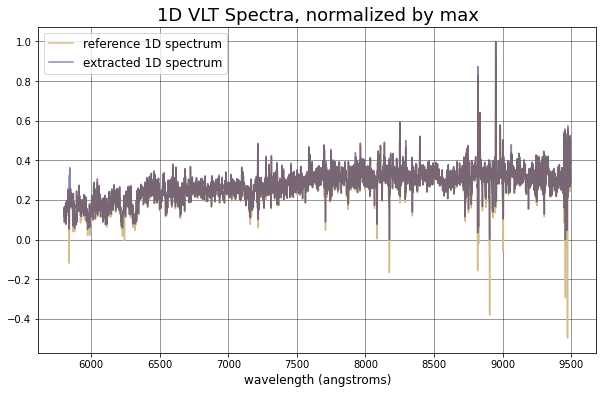

In [20]:
fig6, ax6 = plt.subplots(figsize=(10, 6))
ax6.plot(wavelengths, vlt_ref1[xx1:xx2] / vlt_ref1[xx1:xx2].max(), #alpha=.5,
         c='#d4bd8a', label='reference 1D spectrum')
ax6.plot(wavelengths, r1d / r1d.max(), alpha=.5,
         c='#1d1160', label='extracted 1D spectrum')
ax6.set_xlabel('wavelength (angstroms)')
ax6.set_title('1D VLT Spectra, normalized by max')
ax6.grid()
ax6.legend()

## About this notebook

**Author:** O. Justin Otor, Indigo/JDAT
<br />
**Updated On:** 2022-01

[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 